# One-dimensional advection: upwind solution

The following two code cells contain the complete code of the upwind solution to the one-dimensional advection: the M-file function `run_model_upwind.m` and the M-file script `advection_1d.m`. The first statement in the M-file function checks if the run-time envirnnment is Octave. If so, the logical variable `is_octave` is set to true (1), otherwise it is set to false (0). If it is set to false, it is assumed that the run-time environment is MATLAB R2014b or later, and the plotting of the initial tracer distribution and the animation of the numerical solution uses the appropriate MATLAB as opposed to the Octave syntax.

At the end of the M-file script `advection_1d.m`, there are additional function calls that can be activated by removing the `%` sign. They serve to call the alternative "FTCS" and "leap-frog" solutions, respectively.

Notes:

1. In this Jupyter notebook, the cell that contains the subprogram needs to be executed first in order to create the M-file `run_model_upwind.m` that can then be called from the main program `advection_1d.m`. This is in contrast to GNU Octave or MATLAB, for which the M-file function only needs to be in the same directory as the M-file script from which it is called.
2. Furthermore, in this Jupyter notebook, when executing the M-file script `advection_1d.m`, only the result for the last time step is shown in an inline plot. To view the animation, copy and paste the code to M-files with the correct names and run them in GNU Octave of MATLAB.

In [1]:
%%file run_model_upwind.m

function run_model_upwind(Constants, Sizes, Grids, ... 
                          RunParameters, ModelParameters)
% RUN_MODEL_UPWIND Direct integration of advection using the upwind scheme.
% RUN_MODEL_UPWIND directs the integration of the partial differential equation
% of one-dimensional advection using the "upwind" scheme.

% Author:           Andre Paul
% Written:          2011-11-30
% Last updated:     2019-11-14

% Check if the environment is Octave
is_octave = (exist ('OCTAVE_VERSION', 'builtin') > 0);

% Retrieve parameters and variable(s) from structure arrays
SECONDS_PER_DAY = Constants.SECONDS_PER_DAY;
M2KM            = Constants.M2KM;
Ny              = Sizes.Ny;
yC              = Grids.yC;   
yA              = Grids.yA;
volume          = Grids.volume;
deltaT          = RunParameters.deltaT;
startTime       = RunParameters.startTime;
nTimeSteps      = RunParameters.nTimeSteps;
vVel            = ModelParameters.vVel;
initialTracer   = ModelParameters.initialTracer;

% Set initial conditions
myTime    = startTime;
tracer    = initialTracer;
tracerNm1 = tracer;     % tracer at time level n - 1

% Initialize plot (tracer concentration)
if is_octave
    % -- code to run in Octave here --
    p1 = plot(yC*M2KM, tracer, 'r');
    set(p1,'linewidth', 2);
else
    % -- code to run in MATLAB R2014b and later here --   
    h = animatedline(yC*M2KM, tracer, 'Color', 'r', 'LineWidth', 2);
end
grid on
axis([0 4000.0 -0.5 1.5]);
set(gca, 'FontSize', 18)
xlabel('Location y/km', 'FontSize', 18)
ylabel('Tracer concentration C', 'FontSize', 18)
title('One-dimensional advection', 'FontSize', 20)

% Preallocate arrays for speed
afy     = zeros(Ny + 1, 1); % advective flux in Y direction
vTrans  = zeros(Ny + 1, 1); % meridional volume transport through cell
gTracer = zeros(Ny    , 1); % tendency due to advection

% Time loop (myIter = iteration counter)
for myIter=1:nTimeSteps
    
    % Record simulated time
    myTime = myTime + deltaT;

    % Calculate common factors (e.g., volume fluxes) on right-hand side
    for j=1:Ny
        vTrans(j) = vVel(j)*yA(j);
    end

    % Calculate advective flux in Y direction
    for j=2:Ny
        % Use "upwind" scheme
        if vTrans(j) > 0.0
            afy(j) = vTrans(j)*tracer(j - 1);
        else
            afy(j) = vTrans(j)*tracer(j);
        end
    end

    % Calculate surface tracer tendency due to internal processes
    % (here advection only)
    for j=1:Ny
        % Divergence of fluxes
        gTracer(j) = (afy(j) - afy(j + 1))/volume(j);
    end

    % Step surface tracer forward in time 
    % (by "Euler forward" or "forward-in-time" (FT) method)
    tracer = tracer + deltaT*gTracer;
   
    % Plot values as calculation proceeds
    if is_octave
        % -- code to run in Octave here --
        set(p1, 'XData', yC*M2KM, 'YData', tracer)
    else
        % -- code to run in MATLAB R2014b and later here --   
        clearpoints(h)
        addpoints(h, yC*M2KM, tracer);
    end
    drawnow
    
    % Check for arrival of tracer front
    if tracer(350) > 0.01
        fprintf('Time = %6.3f d\n', myTime/SECONDS_PER_DAY)
        error('Arrival of temperature front');
    end

end % end of time loop

Created file '/Users/andre/Development/advection-1d/run_model_upwind.m'.


Time = 14.694 d
error: Arrival of temperature front
error: called from
    run_model_upwind at line 100 column 9
Elapsed time is 21.2568 seconds.


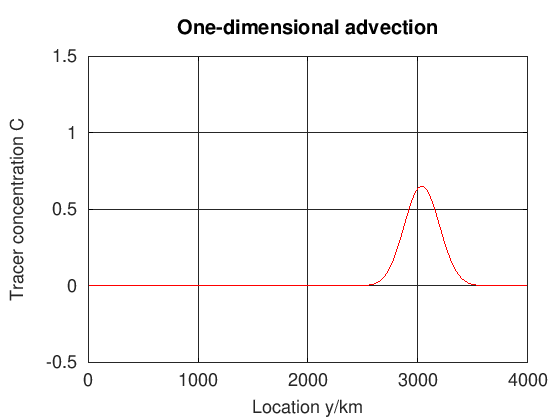

In [2]:
% ADVECTION_1D One-dimensional advection
% ADVECTION_1D solves the one-dimensional advection equation.

% Author:           Andre Paul
% Written:          2011-11-30
% Last updated:     2019-11-14
%
% Execution:        advection_1d
% Dependencies:     run_model_upwind, run_model_ftcs or run_model_leapfrog
%
% >> advection_1d

% Set run parameters, model parameters and initial conditions

% Set named constants
SECONDS_PER_DAY = 86400.0; % seconds per day
M2KM            = 1.0E-03; % m to km conversion factor

% Set array size(s)
Ny = 400; % no. points in Y for the total domain

% Set up horizontal grid and coordinate system
ygOrigin =   0.0;
deltaX   = 100.0E03; % width/m
deltaY   =  10.0E03; % height/m
deltaR   = 100.0;    % depth/m

% Calculate latitudes of N+1 grid-lines/cell faces
yG    = zeros(Ny + 1, 1);
yG(1) = ygOrigin;
for j=1:Ny
    yG(j + 1) = yG(j) + deltaY;
end

% Calculate latitudes of cell centers by averaging
yC    = zeros(Ny, 1);
for j=1:Ny
    yC(j)     = 0.5*(yG(j) + yG(j + 1));
end

% Calculate face areas normal to X direction
yA = zeros(Ny+1, 1);
for j=1:Ny+1
    yA(j) = deltaX*deltaR;
end

% Calculate grid-cell volumes
volume = zeros(Ny, 1);
for j=1:Ny
    volume(j) = deltaR*deltaX*deltaY;
end

% Set other fields
vVel = zeros(Ny + 1, 1); % velocity for advection (m s-1)                                          
for j=1:Ny+1
    vVel(j) = 2.0;
end

% Set run parameters
deltaT     = 1200.0; % time step/s
startTime  =    0.0; % time to start integration/d
endTime    =   20.0; % time to stop integration/d

% Set total number of time steps
nTimeSteps = round((endTime - startTime)*SECONDS_PER_DAY/deltaT);

% Set initial conditions
initialTracer = zeros(Ny  , 1); % tracer
for j=1:Ny
    if yC(j) > 370.0E03 && yC(j) < 630.0E03
        initialTracer(j) = 1.0;
    end    
end

% Store parameters and variable(s) in structure arrays
Constants.SECONDS_PER_DAY     = SECONDS_PER_DAY;
Constants.M2KM                = M2KM; 
Sizes.Ny                      = Ny;
Grids.yC                      = yC;
Grids.yA                      = yA;   
Grids.volume                  = volume;
RunParameters.deltaT          = deltaT;
RunParameters.startTime       = startTime;
RunParameters.nTimeSteps      = nTimeSteps;
ModelParameters.vVel          = vVel;
ModelParameters.initialTracer = initialTracer;

% Run model
figure
tic % time execution - start
run_model_upwind(Constants, Sizes, Grids, RunParameters, ModelParameters);
% run_model_ftcs(Constants, Sizes, Grids, RunParameters, ModelParameters);
% run_model_leapfrog(Constants, Sizes, Grids, RunParameters, ModelParameters);
toc % time execution - stop